# Benchmarkin and Testing

This notebooks contains the generation, analysis and visualisation of the data accompying Project 1 in FYS4411. Several tests and sanity-checks for the various methods are also included.

In [16]:
import sys
sys.path.append("../analysis/")
import numpy as np
import matplotlib.pyplot as plt
import analysis as src
from multiprocessing import Process, Queue
import pandas as pd
import time
from tqdm import tqdm

plt.style.use("../lib/rapport.mplstyle")
%load_ext autoreload
%autoreload 2

def saveto(fig, path, ncol=2):
    lgd = fig.legend(loc='lower left',# mode='expand',-
                     ncol=ncol,
                     bbox_to_anchor=(0.1, 1.02, 1, 0.2))
    fig.savefig(f"../latex/figures/{path}.pdf", bbox_inches='tight')   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing of blocking method:

For testing, we generate a time-series of random variables as $X_i = 0.5X_{i-1} + 0.5z$,  $z = N(0,1)$. Thus, each $X_i$ is normally distributed with mean 0 and variance 1, but is higly corrolated with the previous variables.

In [3]:
np.random.seed(42)
N= 2**18
X = [np.random.normal(0,1)]
for i in range(1, N):
    X.append(0.5*X[-1] + 0.5*np.random.normal(0,1))
X = np.array(X)

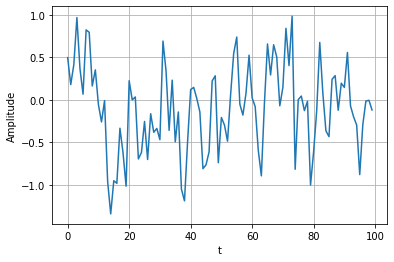

In [4]:
plt.plot(X[:100])
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [5]:
estimatedVar = src.blocking(X, degree = 10)

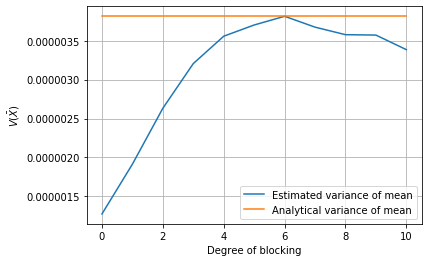

In [6]:
plt.plot(estimatedVar)
plt.plot((0,10), (1/N,1/N))
plt.xlabel("Degree of blocking")
plt.ylabel(r"$V(\bar{X})$")
plt.legend(["Estimated variance of mean", "Analytical variance of mean"])
plt.grid()
plt.show()

### One body density for 1 particle, 1 dimmension. Comparing Bruteforce Sampling with Importance Sampling

In [3]:
conf = src.config()
conf["numPart"] = 1
conf["numDim"] = 1
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [4]:
src.runner(conf)
_, posBruteForce, _, _ = src.readData(conf)

conf["importanceSampling"] = 1  #switching to importance sampling
src.runner(conf)
_, posImportance, _, _ = src.readData(conf)

Calculating and plotting the densities:

In [30]:
bins = np.linspace(-3, 3, 200)
dx = bins[1] - bins[0]
densityBruteForce = src.oneBodyDensity(posBruteForce[0], bins, mode = "1D")/conf["numSteps"]
densityImportance = src.oneBodyDensity(posImportance[0], bins, mode = "1D")/conf["numSteps"]

100%|██████████| 1000000/1000000 [00:05<00:00, 182491.04it/s]


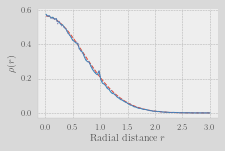

In [32]:
half = len(bins)//2
bins_ = bins[half:]
fig, ax = plt.subplots()
ax.plot(bins_, 1/np.sqrt(np.pi)*np.exp(-bins_**2), "--", label="Analytical")
ax.plot(bins_, densityBruteForce[half:], label="Brute Force")
ax.set_xlabel("Radial distance $r$")
ax.set_ylabel(r"$\rho(r)$")
ax.plot(bins_, densityImportance[half:], linestyle='dotted', label="Importance")
plt.grid()
plt.show()
saveto(fig, "density1", ncol=2)


### Radial one body density for 1 particle, 3 dimmension. Comparing Bruteforce Sampling with Importance sampling

In [33]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [35]:
src.runner(conf)
_, posBruteForce, _, _ = src.readData(conf)

conf["importanceSampling"] = 1  #switching to importance sampling
src.runner(conf)
_, posImportance, _, _ = src.readData(conf)

In [36]:
bins = np.linspace(0, 3, 200)
dx = bins[1] - bins[0]
densityBruteForce = src.oneBodyDensity(posBruteForce[0].reshape(-1,conf["numDim"]), bins)/conf["numSteps"]
densityImportance = src.oneBodyDensity(posImportance[0].reshape(-1,conf["numDim"]), bins)/conf["numSteps"]

100%|██████████| 2000000/2000000 [00:02<00:00, 714143.49it/s]


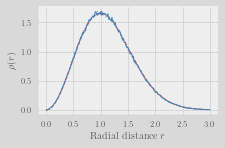

In [38]:
fig, ax = plt.subplots()
ax.plot(bins, 2*4/np.sqrt(np.pi)*np.exp(-bins**2)*bins**2, "--", label="Analytical")
ax.plot(bins, densityBruteForce, label="Brute Force")
ax.set_xlabel("Radial distance $r$")
ax.set_ylabel(r"$\rho(r)$")
ax.plot(bins, densityImportance, linestyle='dotted', label="Importance")
plt.grid()
plt.show()
saveto(fig, "density2", ncol=2)

### Local Energy for various $\alpha$, for 2 particles, 3 dimmensions in harmonic oscillator. Brute force and importance sampling are used and checked against analytical results to verify the methods works correctly in higher dimmension.

#### Brute force sampling:

In [69]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.8
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [70]:
x = np.linspace(0.3, 0.8, 11)
E = []
E_var = []
Var = []
for alpha in tqdm(x):
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    E_var.append(np.std(localEnergies[0])**2)
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 11/11 [00:17<00:00,  1.64s/it]

Done!
Acceptance Rate: 0.5003890000000001


#### Checking appropriate degree of blocking

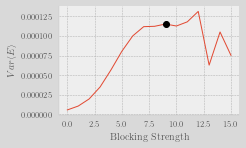

No handles with labels found to put in legend.


In [42]:
fig, ax = plt.subplots()
ax.plot(Var[-1])
ax.plot(9, Var[-1][9], "ko")
ax.set_xlabel("Blocking Strength")
ax.set_ylabel(r"$Var\langle E \rangle$")
plt.grid()
plt.show()
saveto(fig, "blocking1")

#### Plotting estimated energy as a function of alpha for 2 paricles in 3 dimmensions, harmonic oscillator:

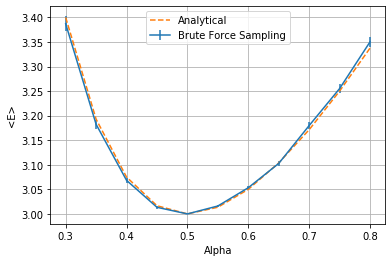

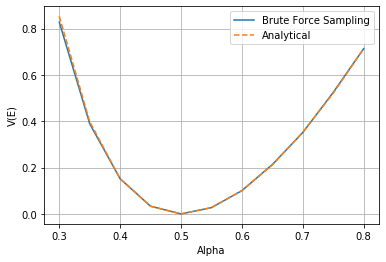

In [9]:
E = np.array(E)
E_var = np.array(E_var)
Var = np.array(Var)
std = np.sqrt(Var[:,9])

fig = plt.figure()
plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Brute Force Sampling"])
plt.grid()
plt.show()
fig.savefig("figures/energy_bruteforce1.pdf", bbox_inches = "tight")

fig = plt.figure()
plt.plot(x, E_var)
plt.plot(x, 6*(0.25 + 3*(1/(8*x) - 0.5*x)**2 - (1/(8*x) + 0.5*x)**2), "--")
plt.xlabel("Alpha")
plt.ylabel("V(E)")
plt.legend(["Brute Force Sampling",  "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/variance_bruteforce1.pdf", bbox_inches = "tight")

#### Importance Sampling:

In [71]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.5
conf["importanceSampling"] = 1 #using importance sampling

conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [72]:
x = np.linspace(0.3, 0.8, 11)
ImE = []
ImE_var = []
ImVar = []

for alpha in tqdm(x):
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    ImE.append(np.mean(localEnergies[0]))
    ImE_var.append(np.std(localEnergies[0])**2)
    ImVar.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 11/11 [00:14<00:00,  1.36s/it]

Done!
Acceptance Rate: 0.691666


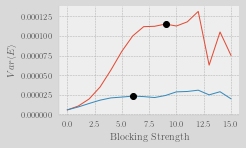

In [50]:
fig, ax = plt.subplots()
ax.plot(Var[-1], label="Brute Force")
ax.plot(9, Var[-1][9], "ko")
ax.plot(ImVar[-1], label="Importance")
ax.plot(6, ImVar[-1][6], "ko")
ax.set_xlabel("Blocking Strength")
ax.set_ylabel(r"$Var\langle E \rangle$")
plt.grid()
plt.show()
saveto(fig, "blocking1")

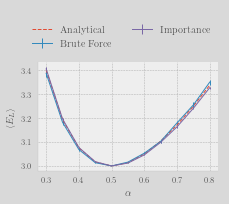

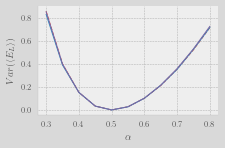

In [75]:
ImE = np.array(ImE)
ImE_var = np.array(ImE_var)
ImVar = np.array(ImVar)
Imstd = np.sqrt(ImVar[:,8])
E = np.array(E)
E_var = np.array(E_var)
Var = np.array(Var)
std = np.sqrt(Var[:,9])

fig = plt.figure()
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--", label="Analytical")
plt.errorbar(x, E, std, label="Brute Force")
plt.errorbar(x, ImE, Imstd, label="Importance")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle E_{L}\rangle$")
plt.grid()
saveto(fig, "energy_importance1", ncol=2)


fig = plt.figure()
plt.plot(x, 6*(0.25 + 3*(1/(8*x) - 0.5*x)**2 - (1/(8*x) + 0.5*x)**2), "--", label="Analytical")
plt.plot(x, E_var, label="Brute Force")
plt.plot(x, ImE_var, label="Importance")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$Var(\langle E_{L}\rangle)$")
plt.grid()
plt.show()
saveto(fig, "variance_importance1")

### Repeated analysis for 40 particles

#### Brute Force

In [60]:
conf = src.config()
cutoff = 2000
conf["numPart"] = 40
conf["numDim"] = 3
conf["numSteps"] = 2**20 + cutoff
conf["stepLength"] = 1.2
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [61]:
src.runner(conf, verbose = True)
localEnergies, _, _, acceptanceRate = src.readData(conf)
E = np.mean(localEnergies[0][cutoff:])
Var = src.blocking(localEnergies[0][cutoff:], degree=18)
print(f"Acceptance Rate: {acceptanceRate[0]}")

Starting simulation
numPart: 40
numDim: 3
numSteps: 1050576
stepLength: 1.2
importanceSampling: 0
alpha: 0.3
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]

Acceptance Rate: 0.534333


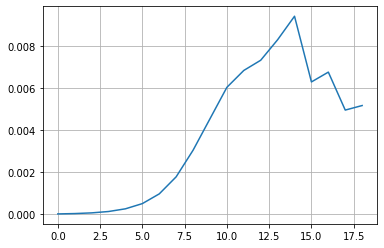

In [24]:
plt.plot(Var)
plt.grid()
plt.show()

In [25]:
std = np.sqrt(Var[13])
a = conf["alpha"]
E_analytical = 3*40*(1/(8*a) + 1/2*a)

print(f"Numerical: <E> = {E} +- {std}")
print(f"Analytical: <E> = {E_analytical}")

Numerical: <E> = 68.06431683397294 +- 0.09104741323267279
Analytical: <E> = 68.0


#### Importance Sampling

In [62]:
conf = src.config()
cutoff = 2000
conf["numPart"] = 40
conf["numDim"] = 3
conf["numSteps"] = 2**20 + cutoff
conf["importanceSampling"] = 1 #importance sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [63]:
conf["stepLength"] = 0.5
src.runner(conf)
localEnergies1, _, _, acceptanceRate1 = src.readData(conf)
E1 = np.mean(localEnergies1[0][cutoff:])
Var1 = src.blocking(localEnergies1[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate1}")

conf["stepLength"] = 1
src.runner(conf)
localEnergies2, _, _, acceptanceRate2 = src.readData(conf)
E2 = np.mean(localEnergies2[0][cutoff:])
Var2 = src.blocking(localEnergies2[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate2}")
      
conf["stepLength"] = 2
src.runner(conf)
localEnergies3, _, _, acceptanceRate3 = src.readData(conf)
E3 = np.mean(localEnergies3[0][cutoff:])
Var3 = src.blocking(localEnergies3[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate3}")



100%|██████████| 18/18 [00:08<00:00,  2.18it/s]


Step length: 0.5. Acceptance rate: [0.926632]


100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Step length: 1. Acceptance rate: [0.795079]


100%|██████████| 18/18 [00:07<00:00,  2.38it/s]

Step length: 2. Acceptance rate: [0.478895]


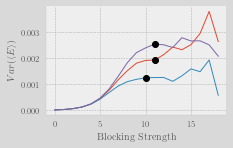

In [67]:
fig = plt.figure()
plt.plot(Var1, label=r"$\delta = 0.5$")
plt.plot(Var2, label=r"$\delta = 1$")
plt.plot(Var3, label=r"$\delta = 2$")
plt.plot(11, Var1[11], "ko")
plt.plot(10, Var2[10], "ko")
plt.plot(11, Var3[11], "ko")

plt.xlabel("Blocking Strength")
plt.ylabel(r"$ Var(\langle E\rangle)$")
plt.grid()
plt.show()
saveto(fig, "blocking3", ncol=3)

In [29]:
std1 = np.sqrt(Var1[11])
std2 = np.sqrt(Var2[10])
std3 = np.sqrt(Var3[11])
a = conf["alpha"]
E_analytical = 3*40*(1/(8*a) + 1/2*a)

print(f"dt = 0.5: <E> = {E1} +- {std1}")
print(f"dt = 1: <E> = {E2} +- {std2}")
print(f"dt = 2: <E> = {E3} +- {std3}")
print(f"Analytical: <E> = {E_analytical}")

dt = 0.5: <E> = 68.0090111966133 +- 0.043963612917920565
dt = 1: <E> = 68.03935787248612 +- 0.03536702229873993
dt = 2: <E> = 67.94214192819595 +- 0.05045206659678679
Analytical: <E> = 68.0


### Repeated analysis for numerically calculated laplacian

In [76]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussianNumerical" #numerical laplacian
conf["Hamiltonian"] = "HarmonicOscillator"

In [77]:
x = np.linspace(0.3, 0.8, 21)
E = []
Var = []
for alpha in x:
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 15/15 [00:00<00:00, 17.78it/s]

Done!
Acceptance Rate: 0.6701050000000001


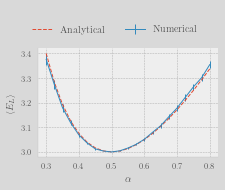

In [78]:
E = np.array(E)
Var = np.array(Var)
std = np.sqrt(Var[:,13])

fig = plt.figure()
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--", label="Analytical")
plt.errorbar(x, E, std, label="Numerical")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle E_{L}\rangle$")
plt.grid()
saveto(fig, "numericalLap", ncol=2)

#### CPU-time differences between analytical and numerical laplacian

In [95]:
conf = src.config()
conf["numDim"] = 3
conf["stepLength"] = 1
conf["importanceSampling"] = 0

conf["alpha"] = 0.4
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Hamiltonian"] = "HarmonicOscillator"

In [100]:
timeAnalytic = []
timeNumeric = []
timeInteractive = []
cycles = 4000000
N = np.array([1, 3, 10, 30, 100])
for n in tqdm(N):
    conf["InitialState"] = "RandomUniform"
    conf["numPart"] = n
    conf["numSteps"] = cycles/n
    conf["Wavefunction"] = "SimpleGaussian"
    
    start = time.time()
    src.runner(conf)
    end = time.time()
    timeAnalytic.append((end - start)/conf["numSteps"])
    
    conf["Wavefunction"] = "SimpleGaussianNumerical"
    
    start = time.time()
    src.runner(conf)
    end = time.time()
    timeNumeric.append((end - start)/conf["numSteps"])
    
    #conf["InitialState"] = "HardshellInitial"
    #conf["Wavefunction"] = "HardshellWavefunction"
    
    #start = time.time()
    #src.runner(conf)
    #end = time.time()
    #timeInteractive.append((end - start)/conf["numSteps"])




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:48<03:14, 48.55s/it]


 40%|████      | 2/5 [01:28<02:17, 45.97s/it]


 60%|██████    | 3/5 [02:10<01:29, 44.79s/it]


 80%|████████  | 4/5 [03:10<00:49, 49.49s/it]


100%|██████████| 5/5 [05:19<00:00, 63.89s/it]


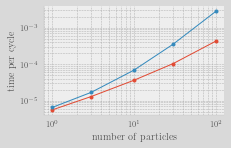

In [101]:
fig = plt.figure()
plt.plot(N,timeAnalytic, '.-', label="Analytical")
plt.plot(N, timeNumeric, '.-', label="Numerical")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of particles")
plt.ylabel("time per cycle")

plt.grid(which="both")
plt.show()
saveto(fig, "numericalTime")
#fig.savefig("figures/numericalTime.pdf", bbox_inches = "tight")

### Thermalization of many particals, using Brute Force Sampling and Importance Sampling

In [33]:
conf = src.config()
conf["numDim"] = 3
conf["numSteps"] = 10000
conf["stepLength"] = 1
conf["importanceSampling"] = 0 #importance sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [34]:
conf["numPart"] = 1
src.runner(conf)
localEnergies1, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 10
src.runner(conf)
localEnergies2, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 20
src.runner(conf)
localEnergies3, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 100
src.runner(conf)
localEnergies4, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

0.5962
0.6036
0.6086
0.6008


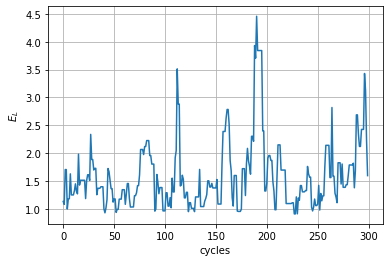

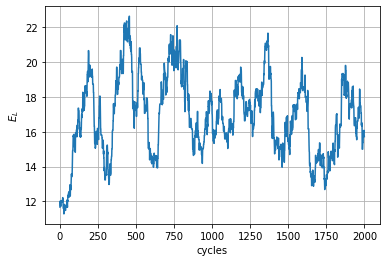

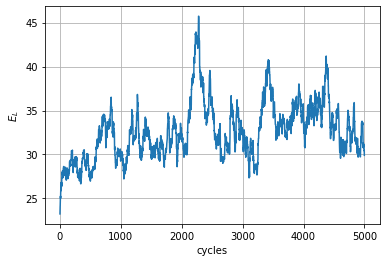

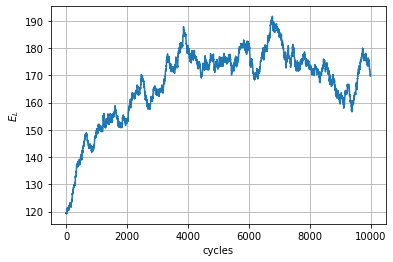

In [35]:
plt.plot(localEnergies1[0][:300])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies2[0][:2000])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies3[0][:5000])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies4[0])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

In [36]:
conf["numPart"] = 100
conf["importanceSampling"] = 1
conf["stepLength"] = 1.6
src.runner(conf, verbose = True)
localEnergies, _, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

Starting simulation
numPart: 100
numDim: 3
numSteps: 10000
stepLength: 1.6
importanceSampling: 1
alpha: 0.3
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------
Acceptance Rate: [0.5954]


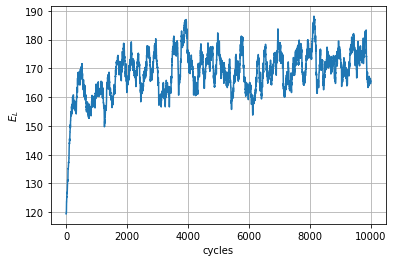

In [37]:
plt.plot(localEnergies[0])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

### One-body density for two interacting particles in 1D, harmonic oscillator

In [102]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 1
conf["numSteps"] = 4000000
conf["stepLength"] = 0.1
conf["importanceSampling"] = 1

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "HardshellWavefunction"
conf["Hamiltonian"] = "HarmonicOscillator"

In [103]:
conf["a"] = 0
src.runner(conf)
_, posNoninteracting, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

conf["a"] = 1
src.runner(conf)
_, posInteracting, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

conf["numPart"] = 3
src.runner(conf)
_, posInteracting3Part, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

Acceptance Rate: [0.992813]
Acceptance Rate: [0.739142]
Acceptance Rate: [0.551578]


In [104]:
bins = np.linspace(-3, 3, 200)
densityNoninteracting = src.oneBodyDensity(posNoninteracting[0], bins, mode = "1D")/conf["numSteps"]
densityInteracting = src.oneBodyDensity(posInteracting[0], bins, mode = "1D")/conf["numSteps"]
densityInteracting3Part = src.oneBodyDensity(posInteracting3Part[0], bins, mode = "1D")/conf["numSteps"]




  0%|          | 0/8000000 [00:00<?, ?it/s]


  0%|          | 18290/8000000 [00:00<00:43, 182893.63it/s]


  0%|          | 34192/8000000 [00:00<00:45, 175009.16it/s]


  1%|          | 56789/8000000 [00:00<00:42, 187708.19it/s]


  1%|          | 80732/8000000 [00:00<00:39, 200715.14it/s]


  1%|▏         | 104798/8000000 [00:00<00:37, 211232.44it/s]


  2%|▏         | 127607/8000000 [00:00<00:36, 216021.91it/s]


  2%|▏         | 152616/8000000 [00:00<00:34, 225224.98it/s]


  2%|▏         | 177802/8000000 [00:00<00:33, 232603.73it/s]


  3%|▎         | 202128/8000000 [00:00<00:33, 235700.03it/s]


  3%|▎         | 226884/8000000 [00:01<00:32, 239136.87it/s]


  3%|▎         | 250451/8000000 [00:01<00:33, 229200.17it/s]


  3%|▎         | 275566/8000000 [00:01<00:32, 235370.69it/s]


  4%|▎         | 299857/8000000 [00:01<00:32, 237581.12it/s]


  4%|▍         | 324392/8000000 [00:01<00:32, 239859.19it/s]


  4%|▍         | 348354/8000000 [00:01<00:32, 237444.16it/s]


  5%|▍    

 35%|███▍      | 2797462/8000000 [00:11<00:21, 236629.65it/s]


 35%|███▌      | 2822910/8000000 [00:11<00:21, 241715.57it/s]


 36%|███▌      | 2848480/8000000 [00:11<00:20, 245746.83it/s]


 36%|███▌      | 2873177/8000000 [00:11<00:20, 246108.37it/s]


 36%|███▌      | 2898506/8000000 [00:11<00:20, 248218.75it/s]


 37%|███▋      | 2924203/8000000 [00:12<00:20, 250780.79it/s]


 37%|███▋      | 2949549/8000000 [00:12<00:20, 251578.30it/s]


 37%|███▋      | 2975012/8000000 [00:12<00:19, 252485.46it/s]


 38%|███▊      | 3000507/8000000 [00:12<00:19, 253219.16it/s]


 38%|███▊      | 3026073/8000000 [00:12<00:19, 253943.69it/s]


 38%|███▊      | 3051618/8000000 [00:12<00:19, 254391.79it/s]


 38%|███▊      | 3077302/8000000 [00:12<00:19, 255118.87it/s]


 39%|███▉      | 3102822/8000000 [00:12<00:19, 254229.56it/s]


 39%|███▉      | 3128457/8000000 [00:12<00:19, 254861.53it/s]


 39%|███▉      | 3153948/8000000 [00:12<00:19, 252693.98it/s]


 40%|███▉      | 3179225/8000000 [00:13<

 71%|███████   | 5640986/8000000 [00:22<00:09, 254199.74it/s]


 71%|███████   | 5666662/8000000 [00:22<00:09, 254961.24it/s]


 71%|███████   | 5692807/8000000 [00:23<00:08, 256873.51it/s]


 71%|███████▏  | 5718500/8000000 [00:23<00:08, 255495.67it/s]


 72%|███████▏  | 5744056/8000000 [00:23<00:08, 254652.93it/s]


 72%|███████▏  | 5769526/8000000 [00:23<00:08, 251827.88it/s]


 72%|███████▏  | 5794978/8000000 [00:23<00:08, 252627.25it/s]


 73%|███████▎  | 5820438/8000000 [00:23<00:08, 253214.49it/s]


 73%|███████▎  | 5845766/8000000 [00:23<00:08, 253203.97it/s]


 73%|███████▎  | 5871091/8000000 [00:23<00:08, 241861.78it/s]


 74%|███████▎  | 5896388/8000000 [00:23<00:08, 245090.18it/s]


 74%|███████▍  | 5921635/8000000 [00:24<00:08, 247256.41it/s]


 74%|███████▍  | 5946861/8000000 [00:24<00:08, 248735.54it/s]


 75%|███████▍  | 5971783/8000000 [00:24<00:08, 245821.86it/s]


 75%|███████▍  | 5997044/8000000 [00:24<00:08, 247819.06it/s]


 75%|███████▌  | 6021859/8000000 [00:24<

  5%|▍         | 388176/8000000 [00:01<00:33, 224349.12it/s]


  5%|▌         | 410716/8000000 [00:01<00:34, 219395.95it/s]


  5%|▌         | 434459/8000000 [00:01<00:33, 224509.89it/s]


  6%|▌         | 458853/8000000 [00:02<00:32, 230003.55it/s]


  6%|▌         | 483821/8000000 [00:02<00:31, 235572.07it/s]


  6%|▋         | 508959/8000000 [00:02<00:31, 240099.29it/s]


  7%|▋         | 533064/8000000 [00:02<00:31, 238910.42it/s]


  7%|▋         | 557878/8000000 [00:02<00:30, 241606.29it/s]


  7%|▋         | 582094/8000000 [00:02<00:32, 226149.89it/s]


  8%|▊         | 607484/8000000 [00:02<00:31, 233815.39it/s]


  8%|▊         | 631099/8000000 [00:02<00:32, 228091.60it/s]


  8%|▊         | 655441/8000000 [00:02<00:31, 232482.78it/s]


  8%|▊         | 679347/8000000 [00:02<00:31, 234416.55it/s]


  9%|▉         | 702903/8000000 [00:03<00:31, 228861.23it/s]


  9%|▉         | 728609/8000000 [00:03<00:30, 236648.29it/s]


  9%|▉         | 754138/8000000 [00:03<00:29, 241946.30

 39%|███▉      | 3142722/8000000 [00:13<00:21, 231152.68it/s]


 40%|███▉      | 3166266/8000000 [00:13<00:20, 232421.47it/s]


 40%|███▉      | 3191723/8000000 [00:13<00:20, 238649.78it/s]


 40%|████      | 3215997/8000000 [00:13<00:19, 239860.67it/s]


 41%|████      | 3240054/8000000 [00:13<00:20, 230902.08it/s]


 41%|████      | 3263266/8000000 [00:13<00:21, 225111.04it/s]


 41%|████      | 3285895/8000000 [00:14<00:21, 219071.94it/s]


 41%|████▏     | 3310808/8000000 [00:14<00:20, 227299.09it/s]


 42%|████▏     | 3334432/8000000 [00:14<00:20, 229907.31it/s]


 42%|████▏     | 3359682/8000000 [00:14<00:19, 236248.01it/s]


 42%|████▏     | 3383435/8000000 [00:14<00:20, 227422.42it/s]


 43%|████▎     | 3408760/8000000 [00:14<00:19, 234599.84it/s]


 43%|████▎     | 3432390/8000000 [00:14<00:20, 224954.30it/s]


 43%|████▎     | 3456635/8000000 [00:14<00:19, 229929.89it/s]


 44%|████▎     | 3480376/8000000 [00:14<00:19, 232123.05it/s]


 44%|████▍     | 3504496/8000000 [00:14<

 73%|███████▎  | 5839219/8000000 [00:25<00:08, 243972.52it/s]


 73%|███████▎  | 5864691/8000000 [00:25<00:08, 247099.01it/s]


 74%|███████▎  | 5890153/8000000 [00:25<00:08, 249306.74it/s]


 74%|███████▍  | 5915519/8000000 [00:25<00:08, 250595.25it/s]


 74%|███████▍  | 5941090/8000000 [00:25<00:08, 252106.17it/s]


 75%|███████▍  | 5966315/8000000 [00:25<00:08, 249721.54it/s]


 75%|███████▍  | 5991618/8000000 [00:25<00:08, 250704.32it/s]


 75%|███████▌  | 6016700/8000000 [00:25<00:08, 246424.48it/s]


 76%|███████▌  | 6041367/8000000 [00:25<00:08, 242155.18it/s]


 76%|███████▌  | 6067206/8000000 [00:26<00:07, 246807.03it/s]


 76%|███████▌  | 6092076/8000000 [00:26<00:07, 247371.25it/s]


 76%|███████▋  | 6117601/8000000 [00:26<00:07, 249682.18it/s]


 77%|███████▋  | 6143160/8000000 [00:26<00:07, 251423.06it/s]


 77%|███████▋  | 6168698/8000000 [00:26<00:07, 252596.57it/s]


 77%|███████▋  | 6194135/8000000 [00:26<00:07, 253123.72it/s]


 78%|███████▊  | 6219460/8000000 [00:26<

  5%|▌         | 620487/12000000 [00:02<00:45, 249756.45it/s]


  5%|▌         | 645588/12000000 [00:02<00:45, 250130.55it/s]


  6%|▌         | 670730/12000000 [00:02<00:45, 250515.71it/s]


  6%|▌         | 695791/12000000 [00:02<00:45, 250297.79it/s]


  6%|▌         | 720828/12000000 [00:02<00:45, 249858.35it/s]


  6%|▌         | 746152/12000000 [00:03<00:44, 250861.09it/s]


  6%|▋         | 771243/12000000 [00:03<00:44, 250785.98it/s]


  7%|▋         | 796658/12000000 [00:03<00:44, 251783.55it/s]


  7%|▋         | 821840/12000000 [00:03<00:44, 251635.10it/s]


  7%|▋         | 847399/12000000 [00:03<00:44, 252808.20it/s]


  7%|▋         | 872702/12000000 [00:03<00:44, 252872.06it/s]


  7%|▋         | 898030/12000000 [00:03<00:43, 252992.39it/s]


  8%|▊         | 923331/12000000 [00:03<00:43, 252771.40it/s]


  8%|▊         | 948610/12000000 [00:03<00:46, 239934.59it/s]


  8%|▊         | 972741/12000000 [00:03<00:47, 231869.42it/s]


  8%|▊         | 996083/12000000 [00:04<

 28%|██▊       | 3359181/12000000 [00:13<00:34, 250126.60it/s]


 28%|██▊       | 3384824/12000000 [00:13<00:34, 251982.25it/s]


 28%|██▊       | 3410382/12000000 [00:14<00:33, 253048.46it/s]


 29%|██▊       | 3436353/12000000 [00:14<00:33, 255008.33it/s]


 29%|██▉       | 3461882/12000000 [00:14<00:34, 250691.52it/s]


 29%|██▉       | 3486988/12000000 [00:14<00:34, 250264.49it/s]


 29%|██▉       | 3512515/12000000 [00:14<00:33, 251744.06it/s]


 29%|██▉       | 3537959/12000000 [00:14<00:33, 252545.46it/s]


 30%|██▉       | 3563736/12000000 [00:14<00:33, 254088.91it/s]


 30%|██▉       | 3589158/12000000 [00:14<00:33, 254115.03it/s]


 30%|███       | 3614579/12000000 [00:14<00:33, 254068.56it/s]


 30%|███       | 3640071/12000000 [00:14<00:32, 254321.10it/s]


 31%|███       | 3665508/12000000 [00:15<00:32, 254179.51it/s]


 31%|███       | 3691467/12000000 [00:15<00:32, 255777.46it/s]


 31%|███       | 3717170/12000000 [00:15<00:32, 256151.28it/s]


 31%|███       | 3742789/

 51%|█████     | 6149676/12000000 [00:24<00:23, 251869.59it/s]


 51%|█████▏    | 6174896/12000000 [00:25<00:23, 249765.51it/s]


 52%|█████▏    | 6199900/12000000 [00:25<00:23, 241789.13it/s]


 52%|█████▏    | 6224651/12000000 [00:25<00:23, 243476.64it/s]


 52%|█████▏    | 6250085/12000000 [00:25<00:23, 246636.67it/s]


 52%|█████▏    | 6274797/12000000 [00:25<00:23, 245177.57it/s]


 52%|█████▏    | 6299398/12000000 [00:25<00:23, 245414.87it/s]


 53%|█████▎    | 6324112/12000000 [00:25<00:23, 245927.50it/s]


 53%|█████▎    | 6348723/12000000 [00:25<00:23, 237908.72it/s]


 53%|█████▎    | 6372583/12000000 [00:25<00:24, 233775.14it/s]


 53%|█████▎    | 6397843/12000000 [00:25<00:23, 239120.34it/s]


 54%|█████▎    | 6422090/12000000 [00:26<00:23, 240113.51it/s]


 54%|█████▎    | 6446156/12000000 [00:26<00:23, 234273.24it/s]


 54%|█████▍    | 6471427/12000000 [00:26<00:23, 239514.90it/s]


 54%|█████▍    | 6495456/12000000 [00:26<00:23, 234570.01it/s]


 54%|█████▍    | 6518990/

 74%|███████▍  | 8878087/12000000 [00:36<00:13, 233466.03it/s]


 74%|███████▍  | 8901602/12000000 [00:36<00:13, 225331.60it/s]


 74%|███████▍  | 8926813/12000000 [00:36<00:13, 232744.68it/s]


 75%|███████▍  | 8951039/12000000 [00:36<00:12, 235517.95it/s]


 75%|███████▍  | 8975939/12000000 [00:36<00:12, 239406.64it/s]


 75%|███████▌  | 9001103/12000000 [00:36<00:12, 242949.47it/s]


 75%|███████▌  | 9026236/12000000 [00:36<00:12, 245403.22it/s]


 75%|███████▌  | 9051517/12000000 [00:37<00:11, 247578.48it/s]


 76%|███████▌  | 9076329/12000000 [00:37<00:12, 238591.83it/s]


 76%|███████▌  | 9101703/12000000 [00:37<00:11, 242941.64it/s]


 76%|███████▌  | 9127167/12000000 [00:37<00:11, 246335.59it/s]


 76%|███████▋  | 9152587/12000000 [00:37<00:11, 248642.36it/s]


 76%|███████▋  | 9178059/12000000 [00:37<00:11, 250433.12it/s]


 77%|███████▋  | 9203578/12000000 [00:37<00:11, 251841.17it/s]


 77%|███████▋  | 9229322/12000000 [00:37<00:10, 253493.72it/s]


 77%|███████▋  | 9254856/

 96%|█████████▋| 11562401/12000000 [00:47<00:01, 243970.94it/s]


 97%|█████████▋| 11586820/12000000 [00:47<00:01, 235537.02it/s]


 97%|█████████▋| 11611068/12000000 [00:47<00:01, 237576.88it/s]


 97%|█████████▋| 11635591/12000000 [00:47<00:01, 239819.57it/s]


 97%|█████████▋| 11661216/12000000 [00:48<00:01, 244520.69it/s]


 97%|█████████▋| 11686722/12000000 [00:48<00:01, 247587.88it/s]


 98%|█████████▊| 11711905/12000000 [00:48<00:01, 248842.34it/s]


 98%|█████████▊| 11737660/12000000 [00:48<00:01, 251390.50it/s]


 98%|█████████▊| 11763113/12000000 [00:48<00:00, 252321.93it/s]


 98%|█████████▊| 11789010/12000000 [00:48<00:00, 254277.98it/s]


 98%|█████████▊| 11814645/12000000 [00:48<00:00, 254895.77it/s]


 99%|█████████▊| 11840149/12000000 [00:48<00:00, 241593.42it/s]


 99%|█████████▉| 11865829/12000000 [00:48<00:00, 245960.92it/s]


 99%|█████████▉| 11890553/12000000 [00:48<00:00, 245628.07it/s]


 99%|█████████▉| 11915205/12000000 [00:49<00:00, 245835.76it/s]


 99%|█████

#### Non-interacting

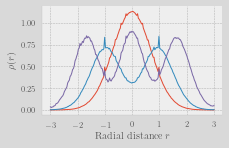

In [108]:
fig = plt.figure()
plt.plot(bins, densityNoninteracting, label="Non-interacting")
plt.plot(bins, densityInteracting, label="N=2")
plt.plot(bins, densityInteracting3Part, label="N=3")
#plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("Radial distance $r$")
plt.ylabel(r"$\rho(r)$")
plt.grid()
plt.show()
saveto(fig, "interactingDensity")

#### Interacting

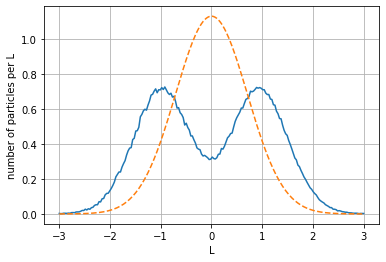

In [45]:
plt.plot(bins, densityInteracting)
plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("number of particles per L")
plt.grid()
plt.show()

#### Three interacting particles

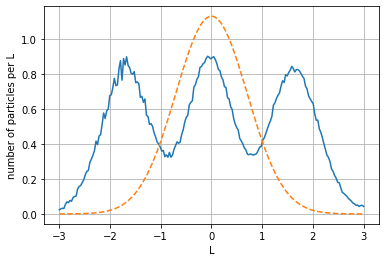

In [46]:
plt.plot(bins, densityInteracting3Part)
plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("number of particles per L")
plt.grid()
plt.show()

### One-body density of many interacting particles in 2D

#### Non-interacting

In [47]:
conf = src.config()
conf["directory"] = "data1"
conf["threads"] = 8
conf["numPart"] = 10
conf["numDim"] = 2
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["alpha"] = 0.4
conf["a"] = 1
conf["omega"] = 1

src.runner(conf, verbose = True)

Starting simulation
numPart: 10
numDim: 2
numSteps: 1000000
stepLength: 0.5
importanceSampling: 0
alpha: 0.4
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------


In [48]:
r = np.linspace(-5, 5, 200)


def f(q,i):
    pos = pd.read_csv(f"data1/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(conf["threads"])]

for p in processes:
    p.start()
 

density = q.get()
for i in range(conf["threads"]-1):
    density += q.get()

density /= conf["threads"]

100%|██████████| 10000000/10000000 [00:22<00:00, 449701.92it/s]


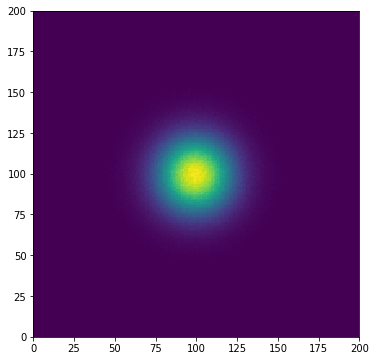

In [49]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

#### Interacting

In [50]:
conf = src.config()
conf["directory"] = "data2"
conf["threads"] = 8
conf["numPart"] = 10
conf["numDim"] = 2
conf["numSteps"] = 1000000
conf["stepLength"] = 0.01
conf["importanceSampling"] = 1
conf["alpha"] = 0.5
conf["a"] = 0.7
conf["omega"] = 1

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "HardshellWavefunction"
conf["Hamiltonian"] = "HarmonicOscillator"

src.runner(conf, verbose = True)

Starting simulation
numPart: 10
numDim: 2
numSteps: 1000000
stepLength: 0.01
importanceSampling: 1
alpha: 0.5
a: 0.7
omega: 1
InitialState: HardshellInitial
WaveFunction: HardshellWavefunction
Hamiltonian: HarmonicOscillator
Done!
------------


In [51]:
r = np.linspace(-5, 5, 200)


def f(q,i):
    pos = pd.read_csv(f"data2/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(conf["threads"])]

for p in processes:
    p.start()
 

density = q.get()
for i in range(conf["threads"]-1):
    density += q.get()

density /= conf["threads"]

100%|██████████| 10000000/10000000 [00:22<00:00, 438340.82it/s]


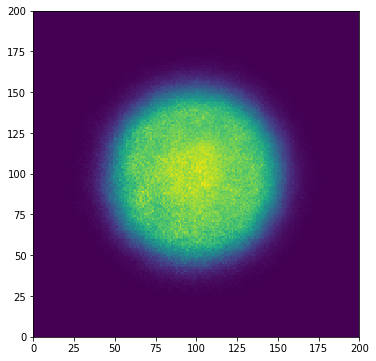

In [52]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

### Gradient decent

In [120]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 10000
conf["stepLength"] = 1
conf["importanceSampling"] = 1
conf["omega"] = 1


conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

alphas = []
mu = 0.01

a0s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5]
for a0 in a0s:
    conf["alpha"] = a0
    alphaArray = []
    for i in range(50):
        src.runner(conf)
        localEnergies, _, psiGrad, _ = src.readData(conf)
        grad = src.calculateGradient(localEnergies, psiGrad)

        conf["alpha"] -= mu*grad
        alphaArray.append(conf["alpha"])
    alphas.append(alphaArray)

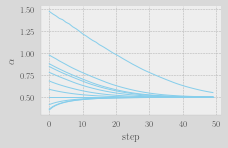

No handles with labels found to put in legend.


In [122]:
fig = plt.figure()
for (a0, alpha) in zip(a0s, alphas):
    plt.plot(alpha, c="skyblue")
plt.xlabel("step")
plt.ylabel(r"$\alpha$")
plt.grid()
plt.show()
saveto(fig, "gd")